# Package Imports

In [1]:
import glob
import os
import numpy as np
import pandas as pd
import sqlite3 as sql
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import seaborn as sns
sns.set(font_scale=1.2, context="paper", style="ticks")
sns.set_palette("viridis")

%matplotlib inline

import plotly
plotly.offline.init_notebook_mode(connected=True)

import sys
sys.path.append("..")

In [2]:
import thor

Config = thor.Config()

In [3]:
DATABASE = "../data/msst_survey.db"
con = sql.connect(DATABASE)

## Config

In [4]:
from thor import propagateTestParticle

## Plotting Code

In [5]:
from thor.plotting import plotProjections
from thor.plotting import plotProjections3D
from thor.plotting import plotObservations
from thor.plotting import plotObservations3D
from thor.plotting import plotBinnedContour
from thor.plotting import plotScatterContour
from thor.plotting import plotCell
from thor.plotting import plotProjectionVelocitiesFindable
from thor.plotting import plotProjectionVelocitiesFound
from thor.plotting import plotProjectionVelocitiesMissed
from thor.plotting import plotOrbitsFindable
from thor.plotting import plotOrbitsFound
from thor.plotting import plotOrbitsMissed
from thor.plotting import _setPercentage

## Classes 

In [6]:
from thor import Cell
from thor import TestParticle

## Functions

In [7]:
from thor import findExposureTimes
from thor import findAverageOrbits
from thor import rangeAndShift
from thor import clusterAndLink
from thor import analyzeClusters
from thor import analyzeObservations
from thor import analyzeProjections
from thor import calcLinkageEfficiency
from thor import grabLinkedDetections

# Load Data

In [8]:
observationsNoNoise = pd.read_sql("""SELECT * FROM observations WHERE night < 59755""", con)
print(len(observationsNoNoise))
observationsNoNoise.drop_duplicates(subset=["designation", "exp_mjd"], inplace=True)
print(len(observationsNoNoise))
noise = pd.read_sql("""SELECT * FROM noise_100 WHERE night < 59755""", con)
noise["obsId"] = np.arange(observationsNoNoise["obsId"].values[-1] + 1, observationsNoNoise["obsId"].values[-1] + 1 + len(noise))

2527774
2525712


In [9]:
observations = pd.concat([observationsNoNoise, noise], sort=False)
observations.reset_index(inplace=True, drop=True)
del observationsNoNoise
del noise

In [10]:
survey = pd.read_sql("""SELECT * FROM survey""", con)

In [11]:
orbits = pd.read_sql("""SELECT * FROM mpcOrbitCat""", con)
# Only grab the orbits of objects with observations
orbits = orbits[orbits["designation"].isin(observations["designation"].unique())]
orbits.drop_duplicates(subset=["designation"], inplace=True)

In [12]:
neos = orbits[orbits["a_au"] <= 1.3]["designation"].values

(140, 200)

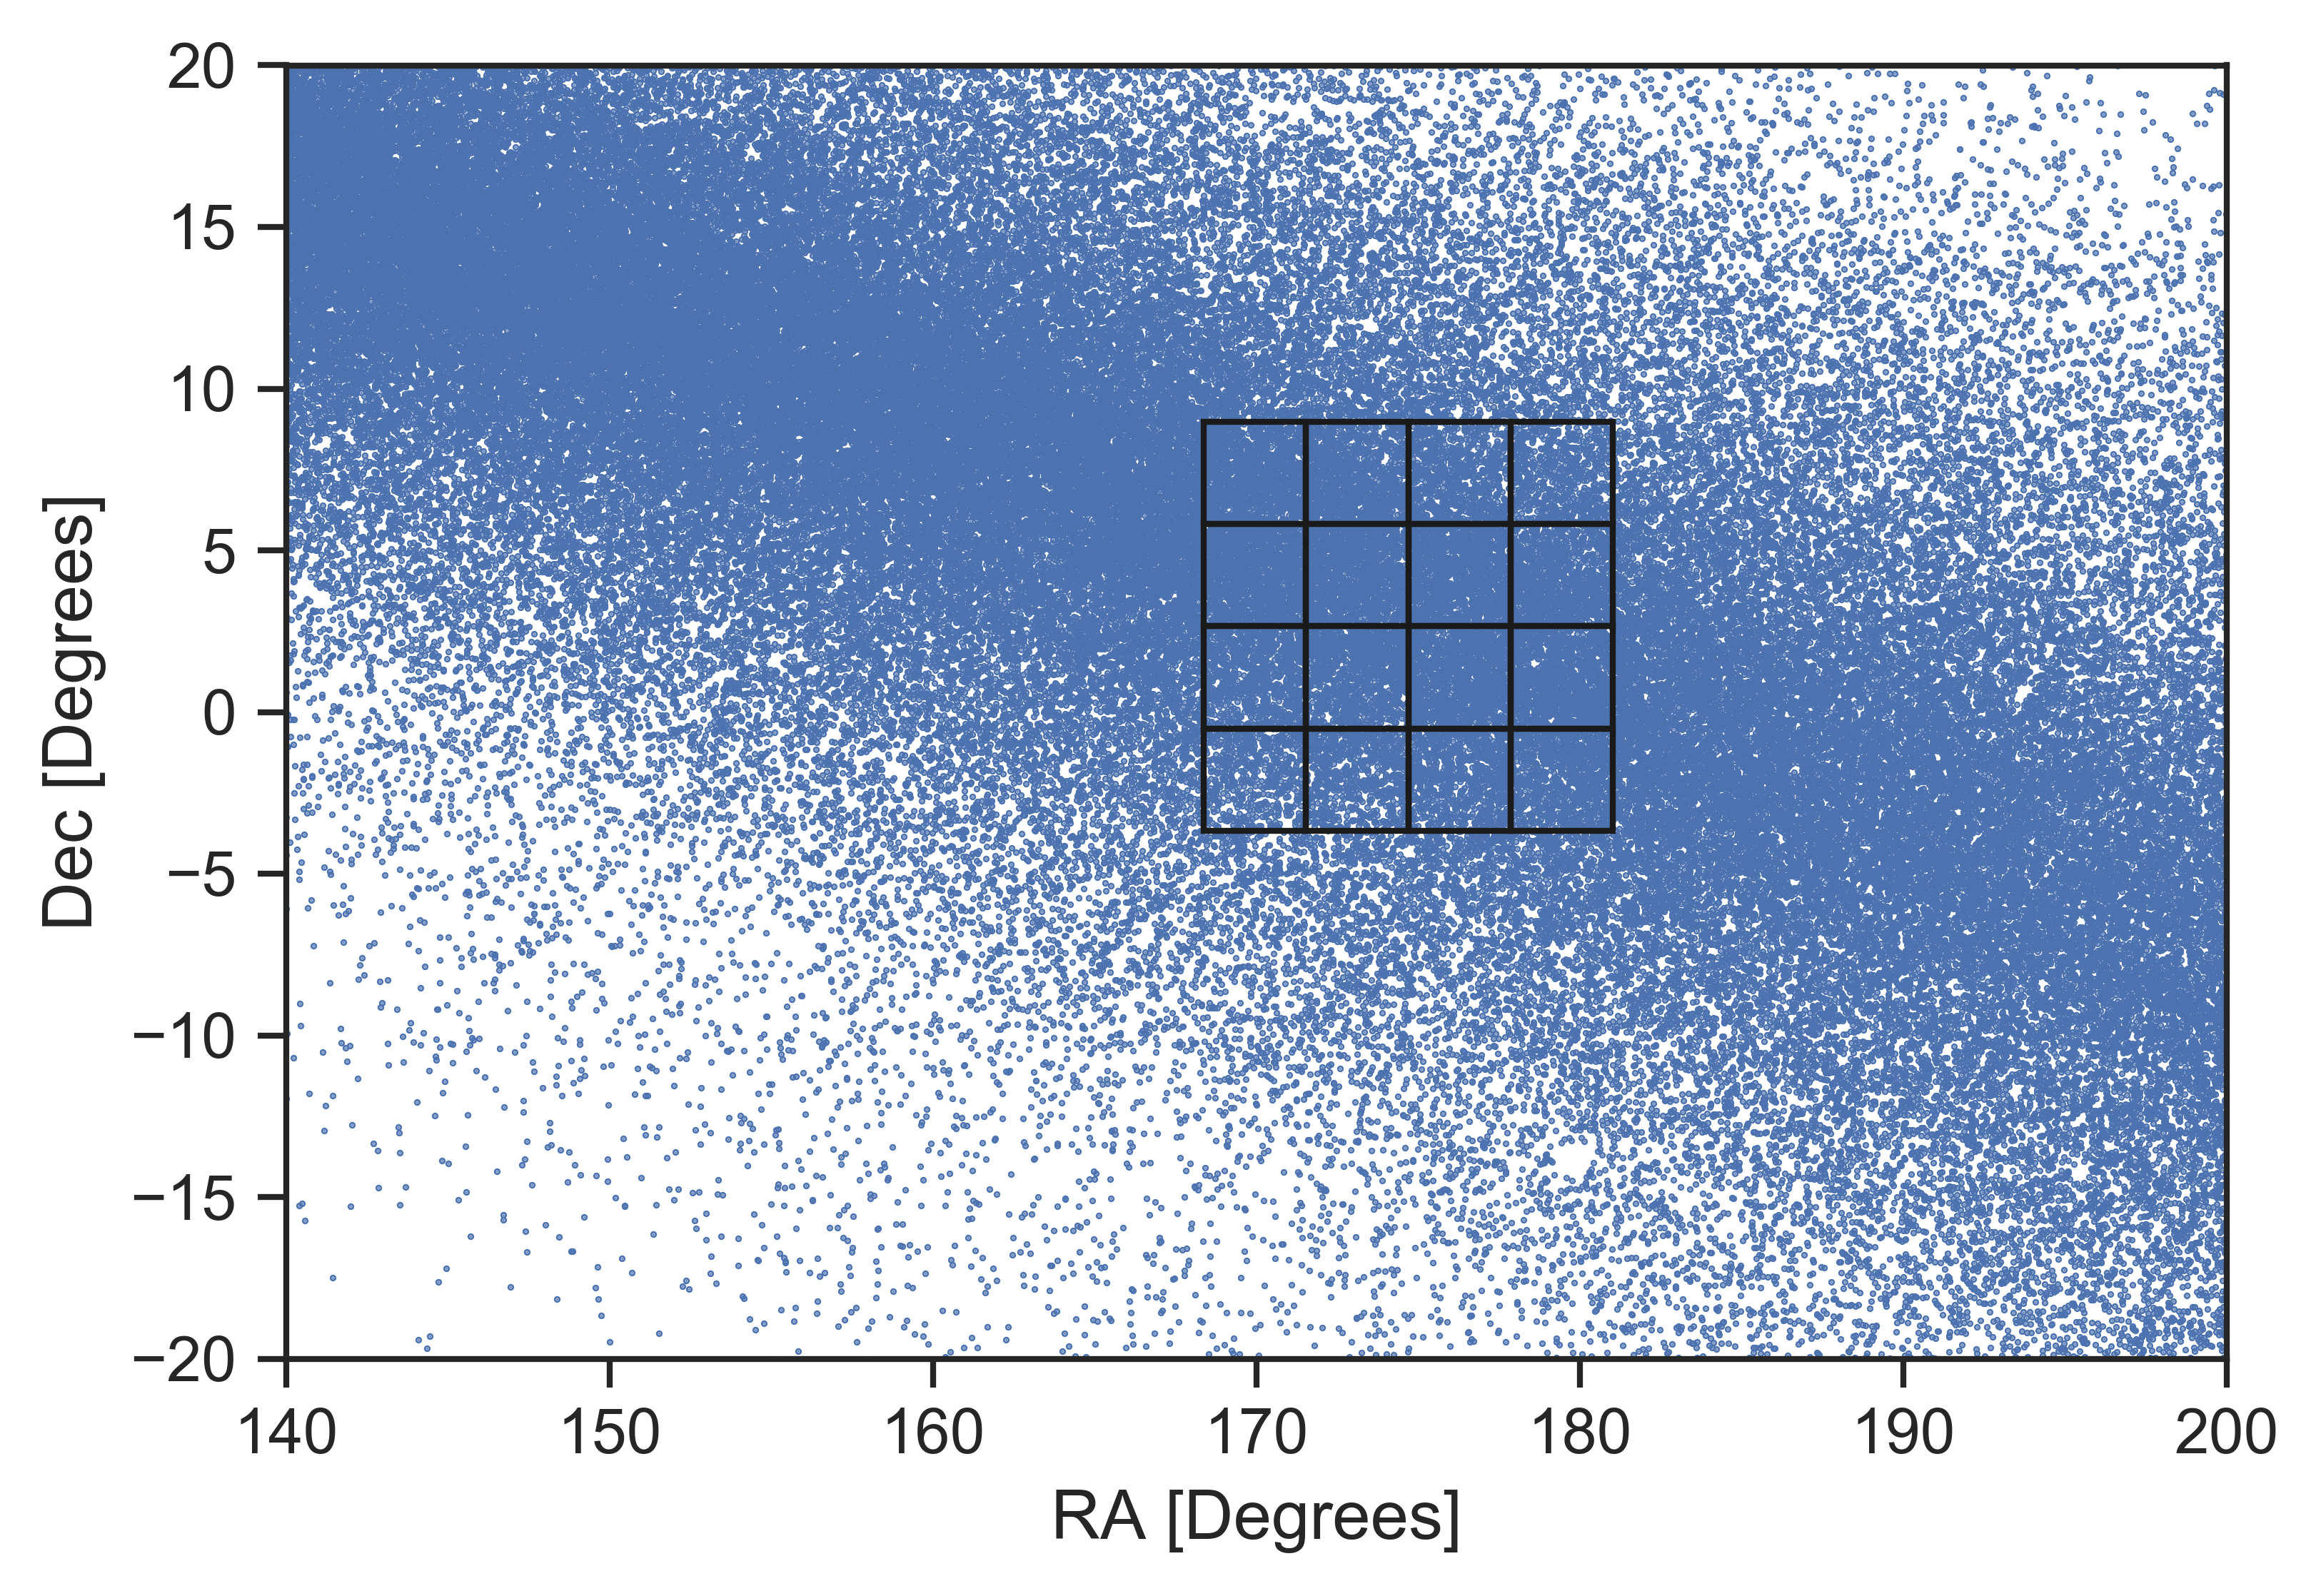

In [13]:
# Plot footprint
fieldArea = 10
xField = np.sqrt(fieldArea)
yField = np.sqrt(fieldArea)

fig, ax = plt.subplots(1, 1, dpi=600)
ax.set_xlabel("RA [Degrees]")
ax.set_ylabel("Dec [Degrees]")
fields = [405, 406, 407, 408, 433, 434, 435, 436, 445, 446, 447, 448, 473, 474, 475, 476]
for xx, yy in zip(survey[(survey["night"] == survey["night"].min()) & (survey["fieldId"].isin(fields))]["fieldRA_deg"].values, 
                  survey[(survey["night"] == survey["night"].min()) & (survey["fieldId"].isin(fields))]["fieldDec_deg"].values):
    ax.add_patch(patches.Rectangle((xx-xField/2, yy-yField/2), xField, yField, fill=False, lw=1, color="k"))
ax.scatter(observations[(observations["night"] == survey["night"].min()) & (observations["designation"] != "NS")]["RA_deg"].values, 
           observations[(observations["night"] == survey["night"].min()) & (observations["designation"] != "NS")]["Dec_deg"].values,
           s=0.1,
           c="b")
ax.set_aspect("equal")
ax.set_ylim(-20, 20)
ax.set_xlim(140, 200)

## Make Reduced Survey

In [14]:
fields = [405, 406, 407, 408, 433, 434, 435, 436, 445, 446, 447, 448, 473, 474, 475, 476]
observations = observations[observations["fieldId"].isin(fields)]

In [16]:
#observations.to_csv("../analysis/msst_4x4/observations.txt", sep=" ", index=False)

In [17]:
orbits = orbits[orbits["designation"].isin(observations["designation"].unique())]
orbits.drop_duplicates(subset="designation", inplace=True)

In [18]:
#orbits.to_csv("../analysis/msst_4x4/orbits.txt", sep=" ", index=False)

(5.642774417833482, 9.132279844018699)

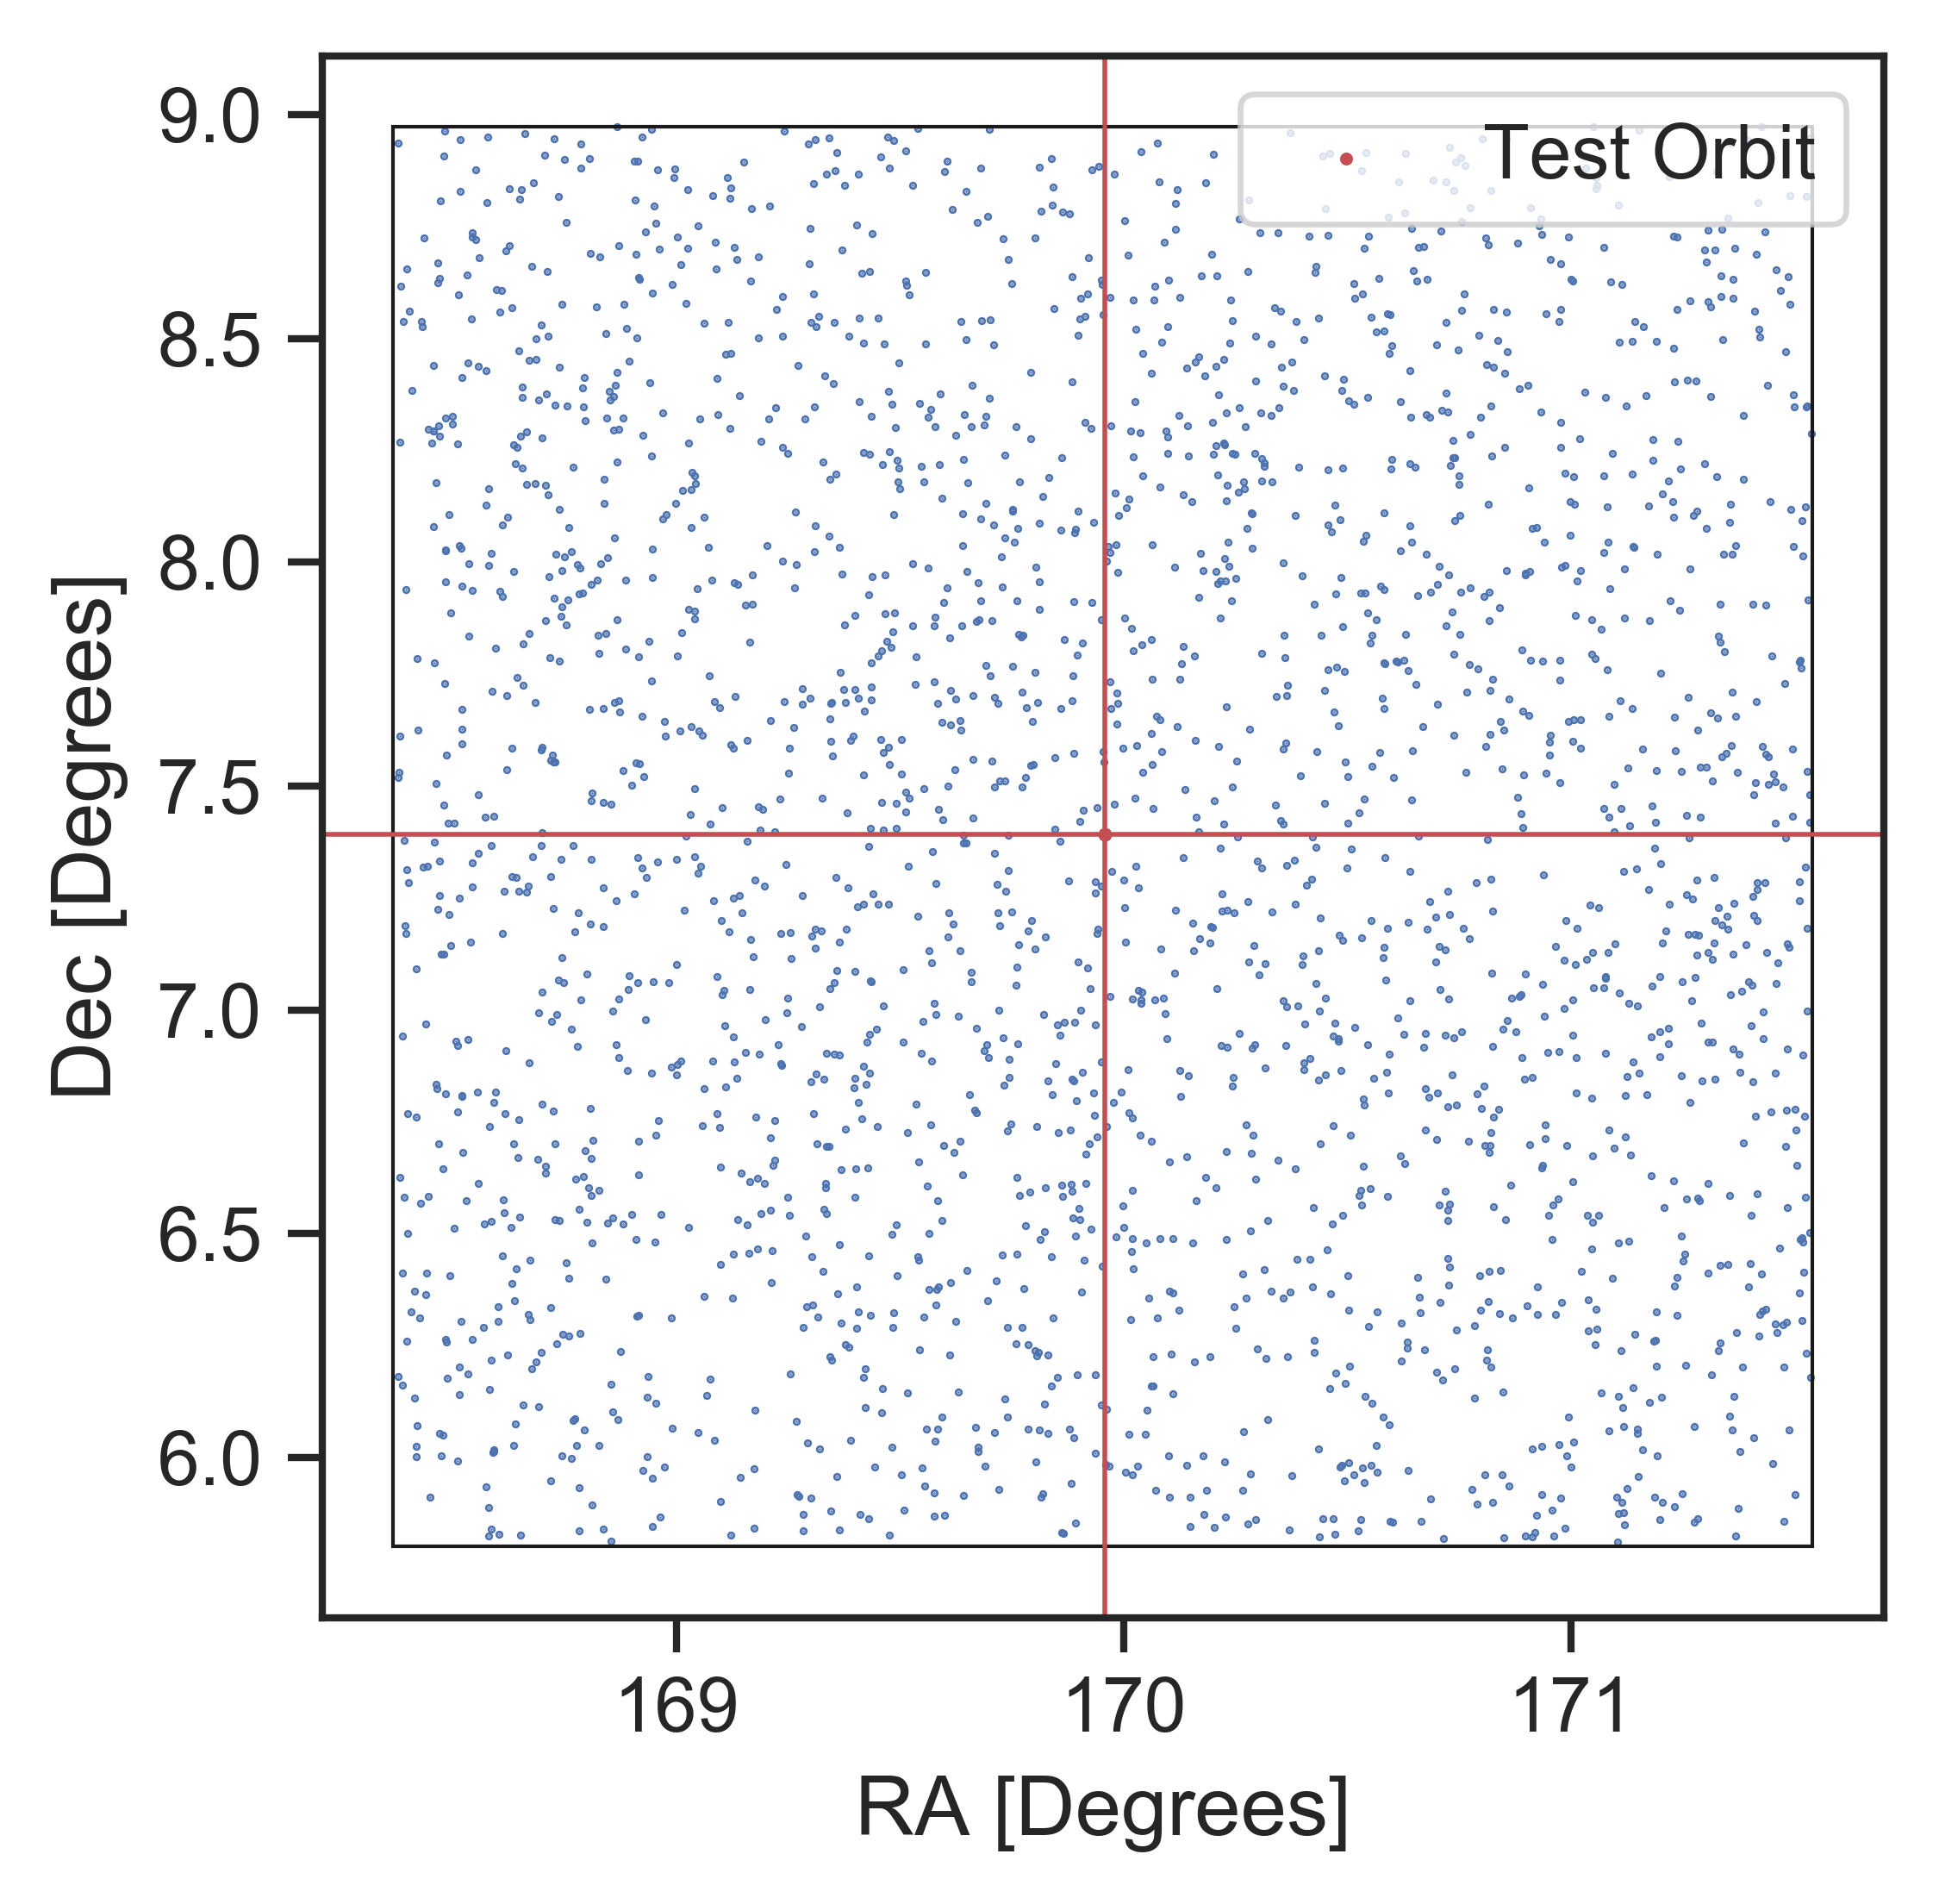

In [19]:
# Plot footprint
fieldArea = 10
xField = np.sqrt(fieldArea)
yField = np.sqrt(fieldArea)

fig, ax = plt.subplots(1, 1, dpi=600)
ax.set_xlabel("RA [Degrees]")
ax.set_ylabel("Dec [Degrees]")
for xx, yy in zip(survey[(survey["night"] == survey["night"].min()) & (survey["fieldId"].isin([405]))]["fieldRA_deg"].values, 
                  survey[(survey["night"] == survey["night"].min()) & (survey["fieldId"].isin([405]))]["fieldDec_deg"].values):
    ax.add_patch(patches.Rectangle((xx-xField/2- 0.01, yy-yField/2 -0.01), xField+0.01, yField+0.01, fill=False, lw=0.5, color="k"))
ax.scatter(observations[(observations["night"] == survey["night"].min()) & (observations["fieldId"].isin([405]))]["RA_deg"].values, 
           observations[(observations["night"] == survey["night"].min()) & (observations["fieldId"].isin([405]))]["Dec_deg"].values,
           s=0.1,
           c="b")
ax.scatter(survey[survey["fieldId"].isin([405])]["fieldRA_deg"].values, survey[survey["fieldId"].isin([405])]["fieldDec_deg"].values, s=1, c="r", 
           label="Test Orbit")
ax.legend()
ax.set_aspect("equal")
xlim = ax.get_xlim()
ylim = ax.get_ylim()
ax.hlines(survey[survey["fieldId"].isin([405])]["fieldDec_deg"].values, *xlim, lw=0.5, color="r")
ax.vlines(survey[survey["fieldId"].isin([405])]["fieldRA_deg"].values, *ylim, lw=0.5, color="r")
ax.set_xlim(xlim)
ax.set_ylim(ylim)

## Analyze Observations

In [20]:
allObjects_survey, summary_survey = analyzeObservations(observations)

THOR: analyzeObservations
-------------------------
Analyzing observations...
Known object observations: 160724
Unknown object observations: 0
False positive observations: 127468
Percent known object observations (%): 55.770
Percent unknown object observations (%): 0.000
Percent false positive observations (%): 44.230
Unique known objects: 25628
Unique known objects with at least 5 detections: 19234

Total time in seconds: 0.34027600288391113
-------------------------



Text(0.55, 47, 'Findable Objects: 19234')

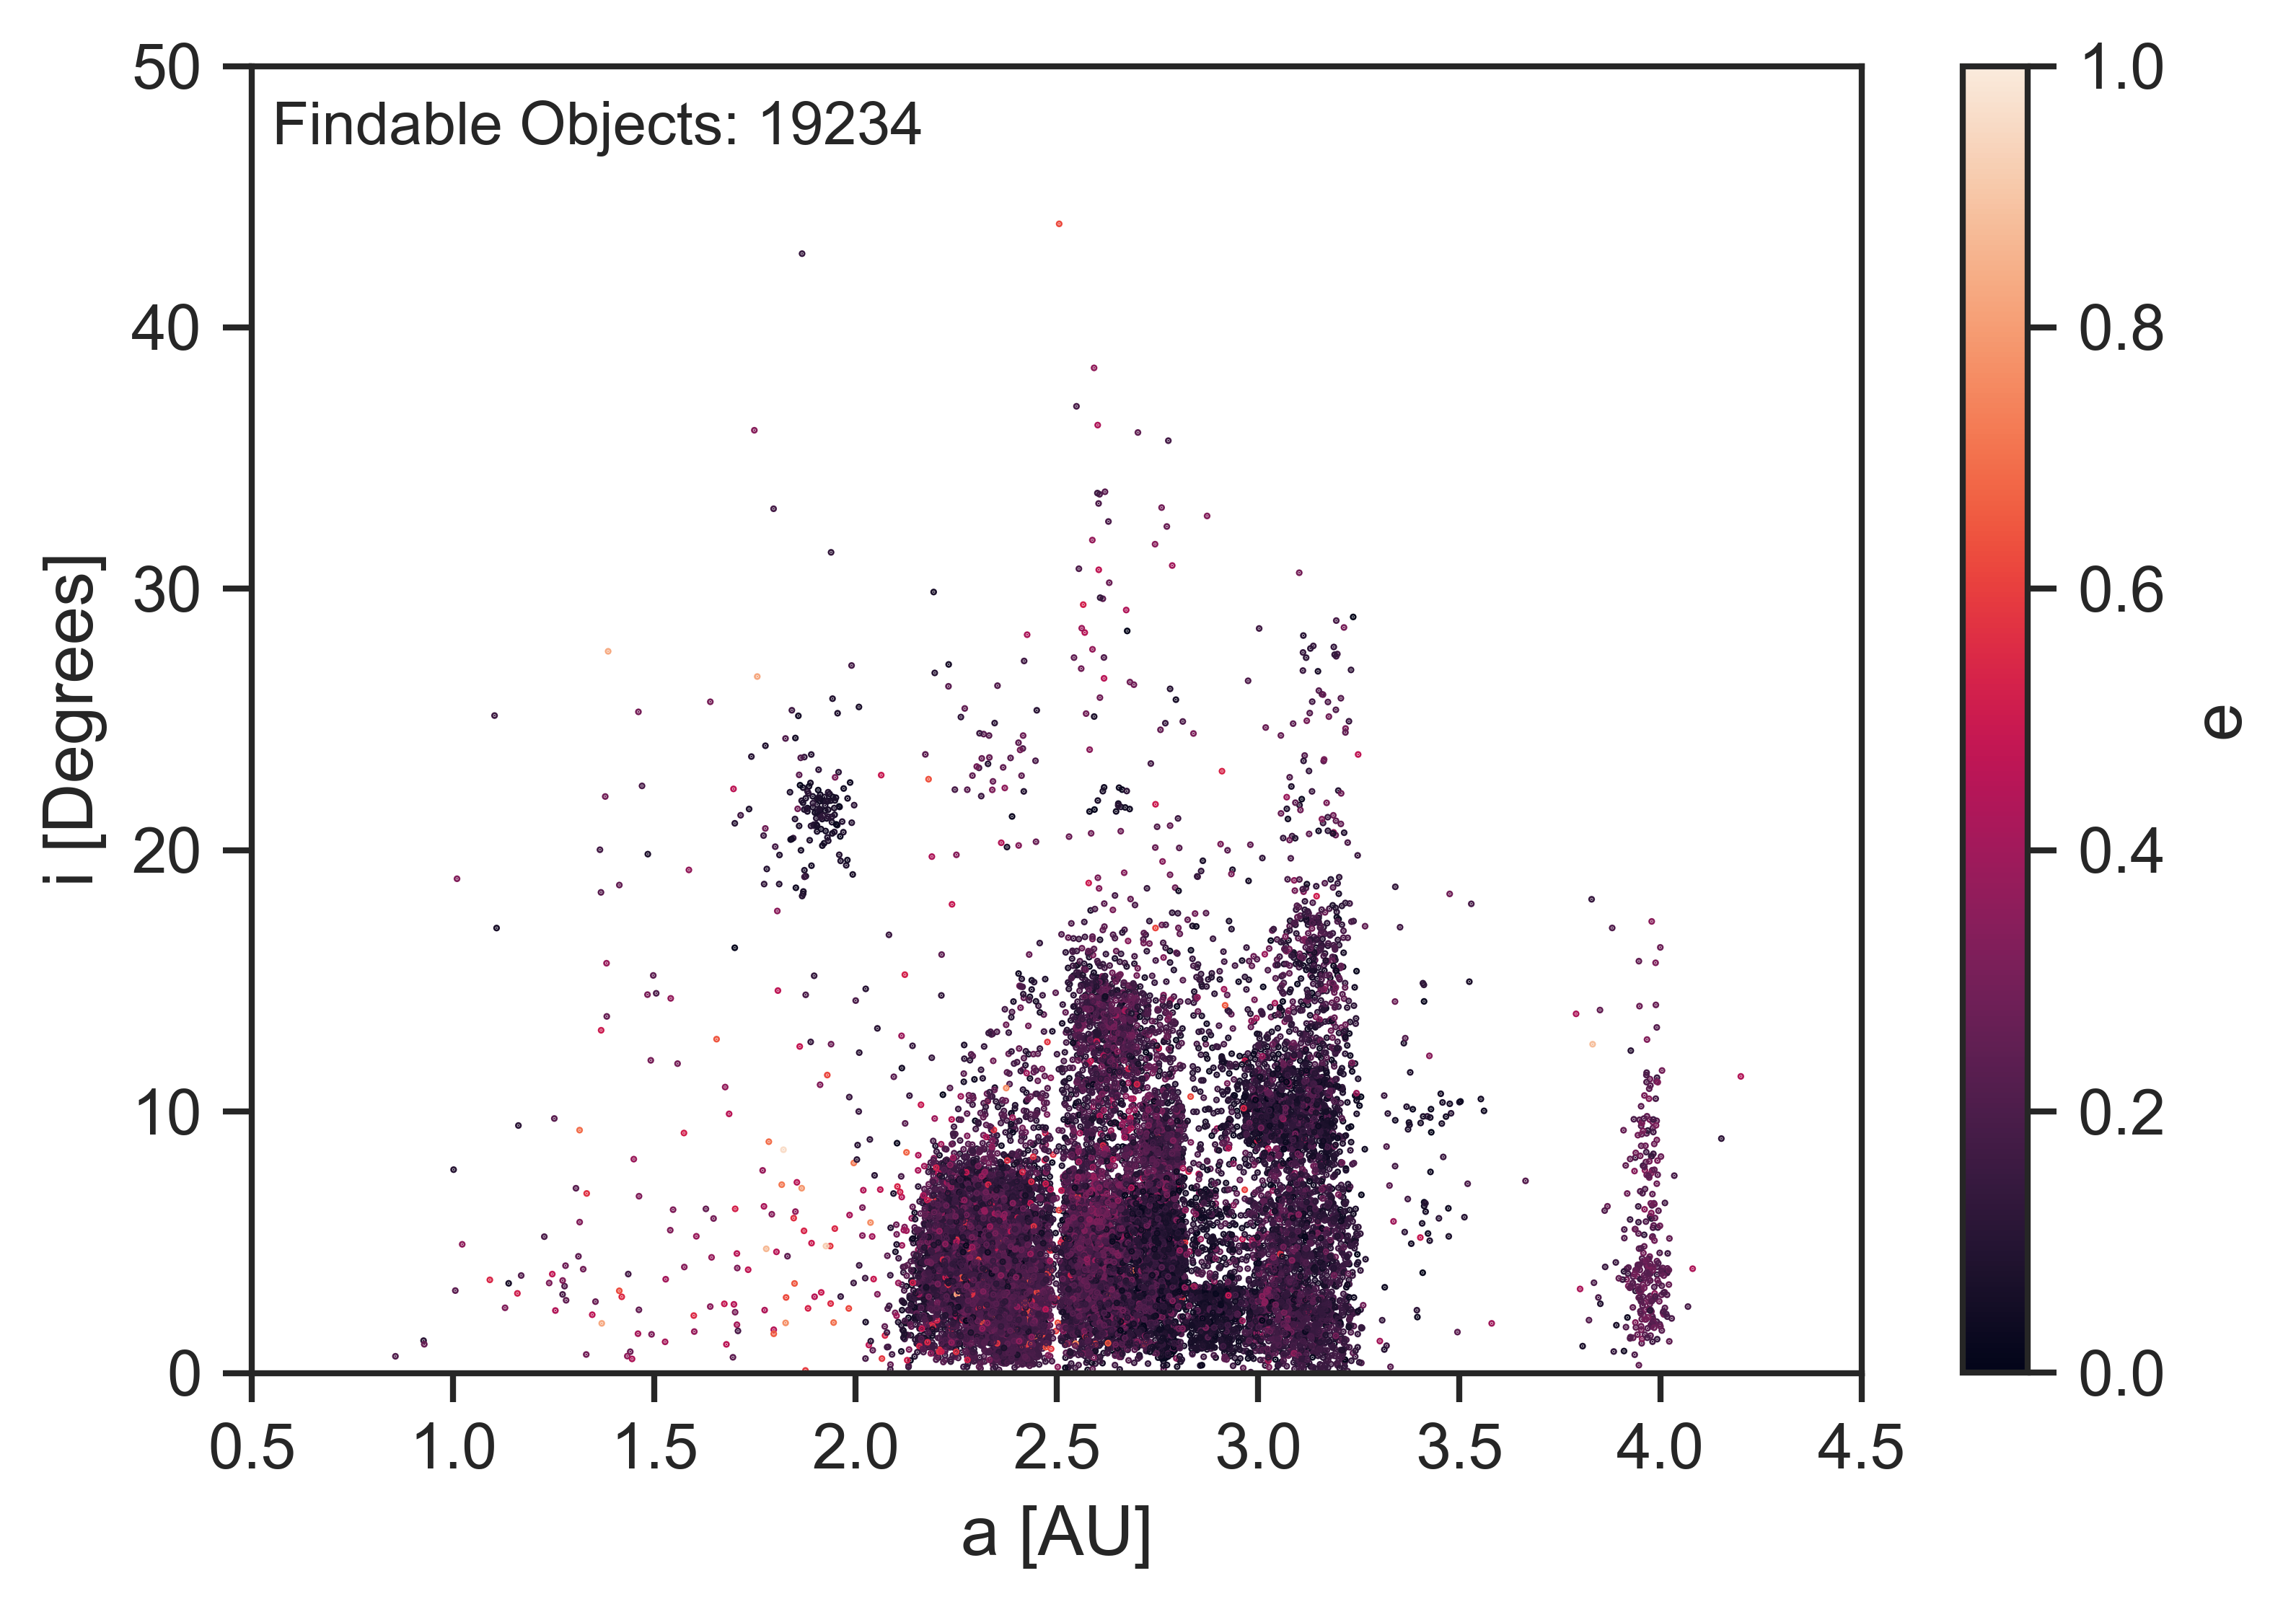

In [21]:
fig, ax = plotOrbitsFindable(allObjects_survey, orbits)
ax.set_xlim(0.5, 4.5)
ax.set_ylim(0, 50)
ax.text(0.55, 47, "Findable Objects: {}".format(len(allObjects_survey[allObjects_survey["findable"] == 1])), size=10)

## Range and Shift

In [22]:
average_orbits = findAverageOrbits(observations[(observations["visitId"] == 434)], rValues=[0.0, 2.0, 3.0, 10.0])

THOR: findAverageObject
-------------------------
Finding average orbit in 3 heliocentric distance bins...
Done.
-------------------------



In [23]:
average_orbits

orbit_id      r_au  HEclObj_dX/dt_au_p_day  HEclObj_dY/dt_au_p_day  \
0         1  1.911496                0.006576               -0.011829   
1         2  2.750141                0.002739               -0.009635   
2         3  3.273321                0.001596               -0.008793   

   HEclObj_dZ/dt_au_p_day       exp_mjd      RA_deg   Dec_deg designation  
0               -0.000484  59740.238194  173.136610  1.492432       85440  
1                0.000020  59740.238194  174.012574  2.616581       K3960  
2                0.000098  59740.238194  173.863821  1.866798       k0230

In [25]:
def runTHOR(observations,
            orbits,
            cellArea=2, 
            cellShape="circle",
            numNights=14,
            mjds="auto",
            dMax=20.0,
            includeEquatorialProjection=True,
            vxRange=[-0.1, 0.1], 
            vyRange=[-0.1, 0.1],
            vxBins=100, 
            vyBins=100,
            vxValues=None,
            vyValues=None,
            threads=5, 
            eps=0.005, 
            minSamples=5,
            contaminationThreshold=0.2,
            unknownIDs=Config.unknownIDs,
            falsePositiveIDs=Config.falsePositiveIDs,
            verbose=True,
            columnMapping=Config.columnMapping):
    """
    Parameters
    ----------
    observations : `~pandas.DataFrame`
    
    orbits : `~pandas.DataFrame`
    
    cellArea : float, optional
    
    cellShape : 
    
    numNights : int, optional
        Number of nights from the first exposure to consider 
        for ranging and shifting. 
        [Default = 14]
    mjds : {'auto', `~numpy.ndarray` (N)}
        If mjds is 'auto', will propagate the particle to middle of each unique night in 
        obervations and look for all detections within an angular search radius (defined by a 
        maximum allowable angular speed) and extract the exposure time. Alternatively, an array
        of exposure times may be passed. 
    dMax : float, optional
        Maximum angular distance (in RA and Dec) permitted when searching for exposure times
        in degrees. 
        [Default = 20.0]
    includeEquatorialProjection : bool, optional
        Include naive shifting in equatorial coordinates without properly projecting
        to the plane of the orbit. This is useful if performance comparisons want to be made.
        [Default = True]
    vxRange : {None, list or `~numpy.ndarray` (2)}
        Maximum and minimum velocity range in x. 
        Will not be used if vxValues are specified. 
        [Default = [-0.1, 0.1]]
    vyRange : {None, list or `~numpy.ndarray` (2)}
        Maximum and minimum velocity range in y. 
        Will not be used if vyValues are specified. 
        [Default = [-0.1, 0.1]]
    vxBins : int, optional
        Length of x-velocity grid between vxRange[0] 
        and vxRange[-1]. Will not be used if vxValues are 
        specified. 
        [Default = 100]
    vyBins: int, optional
        Length of y-velocity grid between vyRange[0] 
        and vyRange[-1]. Will not be used if vyValues are 
        specified. 
        [Default = 100]
    vxValues : {None, `~numpy.ndarray`}, optional
        Values of velocities in x at which to cluster
        and link. 
        [Default = None]
    vyValues : {None, `~numpy.ndarray`}, optional
        Values of velocities in y at which to cluster
        and link. 
        [Default = None]
    threads : int, optional
        Number of threads to use. 
        [Default = 12]
    eps : float, optional
        The maximum distance between two samples for them to be considered 
        as in the same neighborhood. 
        See: http://scikit-learn.org/stable/modules/generated/sklearn.cluster.dbscan.html
        [Default = 0.005]
    minSamples : int, optional
        The number of samples (or total weight) in a neighborhood for a 
        point to be considered as a core point. This includes the point itself.
        See: http://scikit-learn.org/stable/modules/generated/sklearn.cluster.dbscan.html
        [Default = 5]
    contaminationThreshold : float, optional
        Percentage (expressed between 0 and 1) of imposter observations in a cluster permitted for the 
        object to be found. 
        [Default = 0.2]
    
    
    """
    
    linked_objects = []
    linked_detections = []
    summaries = []
    allObjects = []

    for orbit_id in orbits["orbit_id"].unique():
        orbit = orbits[orbits["orbit_id"] == orbit_id]

        # Build a cell with the test orbit at its center
        center = orbit[[columnMapping["RA_deg"], columnMapping["Dec_deg"]]].values[0]
        mjd = orbit[columnMapping["exp_mjd"]].values[0]
        cell = Cell(center, mjd, observations, shape=cellShape, area=cellArea)
        cell.getObservations(columnMapping=columnMapping)

        # Propagate the orbit and gather all nearby detections
        projected_obs = rangeAndShift(
            observations, 
            cell, 
            orbit[[columnMapping["r_au"]]].values[0], 
            orbit[[columnMapping["obj_dx/dt_au_p_day"],
                   columnMapping["obj_dy/dt_au_p_day"],
                   columnMapping["obj_dz/dt_au_p_day"]]].values[0], 
            mjds="auto", 
            dMax=dMax, 
            numNights=numNights,
            includeEquatorialProjection=includeEquatorialProjection,
            verbose=False,
            columnMapping=columnMapping)

        # Analyze propagated observations
        allObjects_projection, summary_projection = analyzeProjections(
            projected_obs[~projected_obs[columnMapping["obs_id"]].isin(linked_detections)],
            columnMapping=columnMapping)
        summary_projection["orbit_id"] = orbit_id
        allObjects_projection["orbit_id"] = np.ones(len(allObjects_projection), dtype=int) * orbit_id

        # Plot projection velocities of findable known objects
        fig, ax = plotProjectionVelocitiesFindable(allObjects_projection, vxRange=vxRange, vyRange=vyRange)

        # Cluster and link
        allClusters_projection, clusterMembers_projection = clusterAndLink(
            projected_obs[~projected_obs[columnMapping["obs_id"]].isin(linked_detections)],
            vxRange=vxRange, 
            vyRange=vyRange,
            vxBins=vxBins, 
            vyBins=vyBins,
            vxValues=vxValues,
            vyValues=vyValues,
            threads=threads, 
            eps=eps, 
            minSamples=minSamples,
            saveFiles=None,
            verbose=True,
            columnMapping=columnMapping)

        # Analyze resulting clusters
        allClusters_projection, clusterMembers_projection, allObjects_projection, summary_projection = analyzeClusters(
            projected_obs[~projected_obs[columnMapping["obs_id"]].isin(linked_detections)],
            allClusters_projection, 
            clusterMembers_projection, 
            allObjects_projection,
            summary_projection,  
            minSamples=minSamples, 
            contaminationThreshold=contaminationThreshold, 
            unknownIDs=unknownIDs,
            falsePositiveIDs=falsePositiveIDs,
            saveFiles=None,
            verbose=True,
            columnMapping=columnMapping)

        # Plot projection velocities of found and missed known objects
        fig, ax = plotProjectionVelocitiesFound(allObjects_projection, vxRange=vxRange, vyRange=vyRange)
        fig, ax = plotProjectionVelocitiesMissed(allObjects_projection, vxRange=vxRange, vyRange=vyRange)

        linked_detections_projection = grabLinkedDetections(projected_obs, allClusters_projection, clusterMembers_projection, columnMapping=columnMapping)
        summary_projection["linked_observations"] = len(linked_detections_projection)
        linked_detections = np.concatenate([linked_detections, linked_detections_projection])


        allObjects.append(allObjects_projection)
        summaries.append(summary_projection)

    allObjects = pd.concat(allObjects)
    allObjects.reset_index(inplace=True, drop=True)
    summaries = pd.concat(summaries)
    summaries.reset_index(inplace=True, drop=True)
    
    return allObjects, summaries
        

In [4]:
import os

In [5]:
os.environ

environ{'GREP_COLOR': '1;33',
        'TERM_PROGRAM': 'Apple_Terminal',
        'SHELL': '/bin/bash',
        'TERM': 'xterm-color',
        'CLOUDY_DATA_PATH': '/Users/joachim/packages/cloudy/c13.04/data',
        'MYSQL_PS1': '(\\u@\\h) [\\d]> ',
        'HISTSIZE': '5000',
        'TMPDIR': '/var/folders/5n/0z69dgvs0hz3n78qvqv0tbw80000gn/T/',
        'Apple_PubSub_Socket_Render': '/private/tmp/com.apple.launchd.TDkuRuWMhC/Render',
        'TERM_PROGRAM_VERSION': '421.1',
        'GIT_HOSTING': 'git@git.domain.com',
        'TERM_SESSION_ID': '9076D136-6FC3-4AFE-8B19-B529FA60869D',
        'USER': 'joachim',
        'BASH_IT_THEME': 'zork',
        'SCM_CHECK': 'true',
        'SSH_AUTH_SOCK': '/private/tmp/com.apple.launchd.oHvmdH5N2L/Listeners',
        'AUTOFEATURE': 'true autotest',
        'SPS_HOME': '/Users/joachim/repos/cloned/fsps/',
        'BASH_IT': '/Users/joachim/.bash_it',
        'LSCOLORS': 'Gxfxcxdxdxegedabagacad',
        'PATH': '/Users/joachim/anaconda3/bin:/User

In [26]:
allObjects, summaries = runTHOR(observations, average_orbits)

KeyError: 'CONDA_PREFIX'

In [ ]:
allObjects_projections = []

for visit in fields:
    projected_obs = pd.read_csv("../analysis/msst405_4x4/visit_{}/projected_obs.txt".format(visit), sep=" ", index_col=False)
    allObjects_projection, summary_projection = analyzeProjections(projected_obs, minSamples=5)
    allObjects_projection_file = "../analysis/msst405_4x4/visit_{}/allObjects_projection.txt".format(visit)
    allObjects_projections.append(allObjects_projection_file)
    allObjects_projection.to_csv(allObjects_projection_file, sep=" ", index=False)
    summary_projection.to_csv("../analysis/msst405_4x4/visit_{}/summary_projection.txt".format(visit), sep=" ", index=False)
    
    

In [ ]:
allObjects_allProjections = []
for visit in fields:
    allObjects_projection = pd.read_csv("../analysis/msst405_4x4/visit_{}/allObjects_projection.txt".format(visit), sep=" ", index_col=False)
    allObjects_allProjections.append(allObjects_projection)
allObjects_allProjections = pd.concat(allObjects_allProjections)    

In [ ]:
vxRange=[-0.2, 0.2]
vyRange=[-0.2, 0.2]

In [ ]:
findable_projections = calcLinkageFindable(allObjects_allProjections, vxRange=vxRange, vyRange=vyRange)
findable_projections_unique = findable_projections.drop_duplicates(subset=["designation", "findable"])

In [ ]:
len(findable_projections_unique)

In [ ]:
for visit in fields:
    allObjects_projection = pd.read_csv("../analysis/msst405_4x4/visit_{}/allObjects_projection.txt".format(visit), sep=" ", index_col=False)
    fig, ax = plotProjectionVelocitiesFindable(allObjects_projection,  vxRange=vxRange, vyRange=vyRange)
    fig.savefig("../analysis/msst405_4x4/visit_{}/gnomomic_findable_2.png".format(visit))
   

## Cluster and Link 

In [ ]:
import time

linked_obs_ids = []
linked_objects = []

In [ ]:
for visit in fields:
    time_start = time.time()
    print("Running field {}...".format(visit))
    projected_obs = pd.read_csv("../analysis/msst405_4x4/visit_{}/projected_obs.txt".format(visit), sep=" ", index_col=False)
    allObjects_projection = pd.read_csv("../analysis/msst405_4x4/visit_{}/allObjects_projection.txt".format(visit), sep=" ", index_col=False)
    summary_projection = pd.read_csv("../analysis/msst405_4x4/visit_{}/summary_projection.txt".format(visit), sep=" ", index_col=False)
    
    allObjects_projection["found_pure"] = np.NaN * np.ones(len(allObjects_projection))
    allObjects_projection["found_partial"] = np.NaN * np.ones(len(allObjects_projection))
    allObjects_projection["found"] = np.NaN * np.ones(len(allObjects_projection))
    
    print("There are {} observations in the projected space".format(len(projected_obs)))
    
    projected_obs = projected_obs[~projected_obs["obsId"].isin(linked_obs_ids)]
    projected_obs.to_csv("../analysis/msst405_4x4/visit_{}/projected_obs_clustering.txt".format(visit), sep=" ", index=False)
    
    print("Observations already linked: {}".format(len(linked_obs_ids)))
    print("Observations to be clustered: {}".format(len(projected_obs)))
    print("")
    
    allClusters_projection, clusterMembers_projection = clusterAndLink(
        projected_obs, 
        eps=0.005,
        minSamples=5, 
        vxRange=vxRange,
        vyRange=vyRange,
        vxBins=300,
        vyBins=300,
        threads=40)
    
    if len(allClusters_projection) != 0:
        
        allClusters_projection, clusterMembers_projection, allObjects_projection, summary_projection = analyzeClusters(
            projected_obs,
            allClusters_projection, 
            clusterMembers_projection,
            allObjects_projection, 
            summary_projection,
            minSamples=5, 
            contaminationThreshold=0.2)

        fig, ax = plotProjectionVelocitiesFindable(allObjects_projection[~allObjects_projection["designation"].isin(linked_objects)], vxRange=vxRange, vyRange=vyRange)
        fig.savefig("../analysis/msst405_4x4/visit_{}/gnomomic_findable_nongreedy.png".format(visit))

        efficiency = calcLinkageEfficiency(allObjects_projection[~allObjects_projection["designation"].isin(linked_objects)], vxRange=vxRange, vyRange=vyRange)
        linked_obs_ids_projection = grabLinkedDetections(projected_obs, allClusters_projection, clusterMembers_projection)

        summary_projection["efficiency"] = efficiency
        summary_projection["time"] = time.time() - time_start

        allClusters_projection.to_csv("../analysis/msst405_4x4/visit_{}/allClusters.txt".format(visit), sep=" ", index=False)
        clusterMembers_projection.to_csv("../analysis/msst405_4x4/visit_{}/clusterMembers.txt".format(visit), sep=" ", index=False)
        allObjects_projection.to_csv("../analysis/msst405_4x4/visit_{}/allObjects_projection_post.txt".format(visit), sep=" ", index=False)
        summary_projection.to_csv("../analysis/msst405_4x4/visit_{}/summary_projection_post.txt".format(visit), sep=" ", index=False)

        fig, ax = plotProjectionVelocitiesFound(allObjects_projection[~allObjects_projection["designation"].isin(linked_objects)],  vxRange=vxRange, vyRange=vyRange)
        fig.savefig("../analysis/msst405_4x4/visit_{}/gnomomic_found_nongreedy.png".format(visit))

        linked_objects = np.concatenate([allObjects_projection[allObjects_projection["found"] == 1]["designation"].values, linked_objects])
        linked_objects = np.unique(linked_objects)
        linked_obs_ids = np.concatenate([linked_obs_ids_projection, linked_obs_ids])
    else:
        print("No clusters found!!!.")
    print("Done.")
    print("")

In [ ]:
for visit in fields:
    time_start = time.time()
    print("Running field {}...".format(visit))
    projected_obs = pd.read_csv("../analysis/msst405_4x4/visit_{}/projected_obs.txt".format(visit), sep=" ", index_col=False)
    allObjects_projection = pd.read_csv("../analysis/msst405_4x4/visit_{}/allObjects_projection.txt".format(visit), sep=" ", index_col=False)
    summary_projection = pd.read_csv("../analysis/msst405_4x4/visit_{}/summary_projection.txt".format(visit), sep=" ", index_col=False)
    
    allObjects_projection["found_pure"] = np.NaN * np.ones(len(allObjects_projection))
    allObjects_projection["found_partial"] = np.NaN * np.ones(len(allObjects_projection))
    allObjects_projection["found"] = np.NaN * np.ones(len(allObjects_projection))
    
    print("There are {} observations in the projected space".format(len(projected_obs)))
    
    projected_obs = projected_obs[~projected_obs["obsId"].isin(linked_obs_ids)]
    projected_obs.to_csv("../analysis/msst405_4x4/visit_{}/projected_obs_clustering_2.txt".format(visit), sep=" ", index=False)
    
    print("Observations already linked: {}".format(len(linked_obs_ids)))
    print("Observations to be clustered: {}".format(len(projected_obs)))
    print("")
    
    allClusters_projection, clusterMembers_projection = clusterAndLink(
        projected_obs, 
        eps=0.006,
        minSamples=5, 
        vxRange=vxRange,
        vyRange=vyRange,
        vxBins=400,
        vyBins=400,
        threads=40)
    
    if len(allClusters_projection) != 0:
        
        allClusters_projection, clusterMembers_projection, allObjects_projection, summary_projection = analyzeClusters(
            projected_obs,
            allClusters_projection, 
            clusterMembers_projection,
            allObjects_projection, 
            summary_projection,
            minSamples=5, 
            contaminationThreshold=0.2)

        fig, ax = plotProjectionVelocitiesFindable(allObjects_projection[~allObjects_projection["designation"].isin(linked_objects)], vxRange=vxRange, vyRange=vyRange)
        fig.savefig("../analysis/msst405_4x4/visit_{}/gnomomic_findable_nongreedy_2.png".format(visit))

        efficiency = calcLinkageEfficiency(allObjects_projection[~allObjects_projection["designation"].isin(linked_objects)], vxRange=vxRange, vyRange=vyRange)
        linked_obs_ids_projection = grabLinkedDetections(projected_obs, allClusters_projection, clusterMembers_projection)

        summary_projection["efficiency"] = efficiency
        summary_projection["time"] = time.time() - time_start

        allClusters_projection.to_csv("../analysis/msst405_4x4/visit_{}/allClusters_2.txt".format(visit), sep=" ", index=False)
        clusterMembers_projection.to_csv("../analysis/msst405_4x4/visit_{}/clusterMembers_2.txt".format(visit), sep=" ", index=False)
        allObjects_projection.to_csv("../analysis/msst405_4x4/visit_{}/allObjects_projection_post_2.txt".format(visit), sep=" ", index=False)
        summary_projection.to_csv("../analysis/msst405_4x4/visit_{}/summary_projection_post_2.txt".format(visit), sep=" ", index=False)

        fig, ax = plotProjectionVelocitiesFound(allObjects_projection[~allObjects_projection["designation"].isin(linked_objects)],  vxRange=vxRange, vyRange=vyRange)
        fig.savefig("../analysis/msst405_4x4/visit_{}/gnomomic_found_nongreedy_2.png".format(visit))

        linked_objects = np.concatenate([allObjects_projection[allObjects_projection["found"] == 1]["designation"].values, linked_objects])
        linked_objects = np.unique(linked_objects)
        linked_obs_ids = np.concatenate([linked_obs_ids_projection, linked_obs_ids])
    else:
        print("No clusters found!!!.")
    print("Done.")
    print("")

In [ ]:
len(linked_obs_ids)

In [ ]:
np.save("../analysis/msst405_4x4/linked_obs_p2.txt", linked_obs_ids)

In [ ]:
for visit in [434]:
    time_start = time.time()
    print("Running field {}...".format(visit))
    projected_obs = pd.read_csv("../analysis/msst405_4x4/visit_{}_circular/projected_obs.txt".format(visit), sep=" ", index_col=False)
    allObjects_projection = pd.read_csv("../analysis/msst405_4x4/visit_{}_circular/allObjects_projections.txt".format(visit), sep=" ", index_col=False)
    summary_projection = pd.read_csv("../analysis/msst405_4x4/visit_{}_circular/summary_projection.txt".format(visit), sep=" ", index_col=False)
    
    allObjects_projection["found_pure"] = np.NaN * np.ones(len(allObjects_projection))
    allObjects_projection["found_partial"] = np.NaN * np.ones(len(allObjects_projection))
    allObjects_projection["found"] = np.NaN * np.ones(len(allObjects_projection))
    
    print("There are {} observations in the projected space".format(len(projected_obs)))
    
    projected_obs = projected_obs[~projected_obs["obsId"].isin(linked_obs_ids)]
    projected_obs.to_csv("../analysis/msst405_4x4/visit_{}_circular/projected_obs_clustering.txt".format(visit), sep=" ", index=False)
    
    print("Observations already linked: {}".format(len(linked_obs_ids)))
    print("Observations to be clustered: {}".format(len(projected_obs)))
    print("")
    
    allClusters_projection, clusterMembers_projection = clusterAndLink(
        projected_obs, 
        eps=0.005,
        minSamples=5, 
        vxRange=vxRange,
        vyRange=vyRange,
        vxBins=400,
        vyBins=400,
        threads=40)
    
    if len(allClusters_projection) != 0:
        
        allClusters_projection, clusterMembers_projection, allObjects_projection, summary_projection = analyzeClusters(
            projected_obs,
            allClusters_projection, 
            clusterMembers_projection,
            allObjects_projection, 
            summary_projection,
            minSamples=5, 
            contaminationThreshold=0.2)

        fig, ax = plotProjectionVelocitiesFindable(allObjects_projection[~allObjects_projection["designation"].isin(linked_objects)], vxRange=vxRange, vyRange=vyRange)
        fig.savefig("../analysis/msst405_4x4/visit_{}_circular/gnomomic_findable_nongreedy.png".format(visit))

        efficiency = calcLinkageEfficiency(allObjects_projection[~allObjects_projection["designation"].isin(linked_objects)], vxRange=vxRange, vyRange=vyRange)
        linked_obs_ids_projection = grabLinkedDetections(projected_obs, allClusters_projection, clusterMembers_projection)

        summary_projection["efficiency"] = efficiency
        summary_projection["time"] = time.time() - time_start

        allClusters_projection.to_csv("../analysis/msst405_4x4/visit_{}_circular/allClusters.txt".format(visit), sep=" ", index=False)
        clusterMembers_projection.to_csv("../analysis/msst405_4x4/visit_{}_circular/clusterMembers.txt".format(visit), sep=" ", index=False)
        allObjects_projection.to_csv("../analysis/msst405_4x4/visit_{}_circular/allObjects_projection_post.txt".format(visit), sep=" ", index=False)
        summary_projection.to_csv("../analysis/msst405_4x4/visit_{}_circular/summary_projection_post.txt".format(visit), sep=" ", index=False)

        fig, ax = plotProjectionVelocitiesFound(allObjects_projection[~allObjects_projection["designation"].isin(linked_objects)],  vxRange=vxRange, vyRange=vyRange)
        fig.savefig("../analysis/msst405_4x4/visit_{}_circular/gnomomic_found_nongreedy.png".format(visit))

        linked_objects = np.concatenate([allObjects_projection[allObjects_projection["found"] == 1]["designation"].values, linked_objects])
        linked_objects = np.unique(linked_objects)
        linked_obs_ids = np.concatenate([linked_obs_ids_projection, linked_obs_ids])
    else:
        print("No clusters found!!!.")
    print("Done.")
    print("")

In [ ]:
np.save("../analysis/msst405_4x4/linked_obs_p3.txt", linked_obs_ids)

In [ ]:
observations[(observations["r_au"] < 5) & (observations["r_au"] > 2)]["designation"].nunique()

In [ ]:
allObjects_survey.loc[allObjects_survey["designation"].isin(observations[observations["obsId"].isin(linked_obs_ids)]["designation"].unique()), "found"] = 1

In [ ]:
len(allObjects_survey[allObjects_survey["found"] == 1]) / len(allObjects_survey[allObjects_survey["findable"] == 1])

In [ ]:
len(linked_obs_ids)

In [ ]:
linked_objs = observations[observations["obsId"].isin(linked_obs_ids)]["designation"].unique()

In [ ]:
18186/19234

In [ ]:
allObjects_survey.loc[allObjects_survey["found"] != 1, "found"] = 0

In [ ]:
len(linked_objs)

In [ ]:
fig, ax = plotOrbitsFound(allObjects_survey, orbits)
ax.scatter(orbits[orbits["designation"].isin(average_objs["designation"].values)]["a_au"].values, 
           orbits[orbits["designation"].isin(average_objs["designation"].values)]["i_deg"].values, c="r", s=1, label="Test Orbits")
ax.legend()
ax.set_xlim(0.5, 4.5)
ax.set_ylim(0, 50)
ax.text(0.55, 47, "Found Objects: {} (94.55%)".format(len(linked_objs)), size=10)
fig.savefig("../analysis/msst405_4x4/found_orbits.png")

In [ ]:
len(allObjects_survey[allObjects_survey["findable"] == 1]) 

In [ ]:
fig, ax = plotOrbitsMissed(allObjects_survey, orbits)
ax.scatter(orbits[orbits["designation"].isin(average_objs["designation"].values)]["a_au"].values, 
           orbits[orbits["designation"].isin(average_objs["designation"].values)]["i_deg"].values, c="r", s=1, label="Test Orbits")
ax.legend()
ax.set_xlim(0.5, 4.5)
ax.set_ylim(0, 50)
ax.text(0.55, 47, "Missed Objects: {} (5.45%)".format(len(allObjects_survey[allObjects_survey["findable"] == 1]) - len(linked_objs)), size=10)
fig.savefig("../analysis/msst405_4x4/missed_orbits.png")

In [ ]:
findable = orbits[orbits["designation"].isin(allObjects_survey[allObjects_survey["findable"] == 1]["designation"].values)]
found = orbits[orbits["designation"].isin(allObjects_survey[allObjects_survey["found"] == 1]["designation"].values)]

In [ ]:
len(found[(found["a_au"] >= 2.5) & (found["a_au"] <= 5)]) / len(findable[(findable["a_au"] >= 2.5) & (findable["a_au"] <= 5)])

In [ ]:
average_objs = []
for visit in fields:
    average = pd.read_csv("../analysis/msst405_4x4/visit_{}/average_obj.txt".format(visit), sep=" ", index_col=False)
    average_objs.append(average)

average_objs.append(pd.read_csv("../analysis/msst405_4x4/visit_434_circular/average_obj.txt".format(visit), sep=" ", index_col=False))
average_objs = pd.concat(average_objs)


In [ ]:
average_objs

In [ ]:
def grabLinkedDetections(observations, allClusters, clusterMembers, columnMapping=Config.columnMapping):
    """
    Grabs linked observations from pure and partial clusters.
    
    Parameters
    ----------
    observations : 
    
    
    """
    
    
    pure_clusters = allClusters[allClusters["pure"] == 1]["cluster_id"].values
    pure_obs_ids_linked = clusterMembers[clusterMembers["cluster_id"].isin(pure_clusters)]["obs_id"].values

    partial_clusters = allClusters[allClusters["partial"] == 1]["cluster_id"].values
    cluster_designation = clusterMembers[clusterMembers["cluster_id"].isin(partial_clusters)].merge(observations[["obs_d", "designation"]], 
                                                                                                    left_on="obs_id", 
                                                                                                    right_on="obsId")
    cluster_designation = cluster_designation.merge(allClusters[["cluster_id", "linked_object"]])
    partial_obs_ids_linked = cluster_designation[cluster_designation["designation"] == cluster_designation["linked_object"]]["obs_id"].values
    
    linked_obs_ids = np.concatenate([pure_obs_ids_linked, partial_obs_ids_linked])
    return np.unique(linked_obs_ids)

In [ ]:
def runClusterAndLinkOnVisit(observations, 
                             visitId,
                             vxRange=[-0.1, 0.1], 
                             vyRange=[-0.1, 0.1],
                             vxBins=100, 
                             vyBins=100,
                             vxValues=None,
                             vyValues=None,
                             threads=6, 
                             eps=0.005, 
                             minSamples=5,
                             contaminationThreshold=0.2, 
                             saveDir=None,
                             verbose=True,
                             columnMapping=Config.columnMapping):
    """
    Parameters
    ----------
    observations : `~pandas.DataFrame`
        DataFrame containing post-range and shift observations.
    visitId : int
        Visit ID. 
    orbits : `~pandas.DataFrame`
        Orbit catalog.
    avgObject : `~pandas.DataFrame`
        A slice into the observations dataframe
        with the object's corresponding observation.
    vxRange : {None, list or `~numpy.ndarray` (2)}
        Maximum and minimum velocity range in x. 
        Will not be used if vxValues are specified. 
        [Default = [-0.1, 0.1]]
    vxRange : {None, list or `~numpy.ndarray` (2)}
        Maximum and minimum velocity range in y. 
        Will not be used if vyValues are specified. 
        [Default = [-0.1, 0.1]]
    vxBins : int, optional
        Length of x-velocity grid between vxRange[0] 
        and vxRange[-1]. Will not be used if vxValues are 
        specified. 
        [Default = 100]
    vyBins: int, optional
        Length of y-velocity grid between vyRange[0] 
        and vyRange[-1]. Will not be used if vyValues are 
        specified. 
        [Default = 100]
    vxValues : {None, `~numpy.ndarray`}, optional
        Values of velocities in x at which to cluster
        and link. 
        [Default = None]
    vyValues : {None, `~numpy.ndarray`}, optional
        Values of velocities in y at which to cluster
        and link. 
        [Default = None]
    threads : int, optional
        Number of threads to use. 
        [Default = 12]
    eps : float, optional
        The maximum distance between two samples for them to be considered 
        as in the same neighborhood. 
        See: http://scikit-learn.org/stable/modules/generated/sklearn.cluster.dbscan.html
        [Default = 0.005]
    minSamples : int, optional
        The number of samples (or total weight) in a neighborhood for a 
        point to be considered as a core point. This includes the point itself.
        See: http://scikit-learn.org/stable/modules/generated/sklearn.cluster.dbscan.html
        [Default = 5]
    partialThreshold : float, optional
        Percentage (expressed between 0 and 1) of observations in a cluster required for the 
        object to be found. 
        [Default = 0.8]
    saveDir : {None, str}, optional
        Directory where to save outputs inluding plots. Will create
        a sub-directory inside directory. 
        [Default = None]
    verbose : bool, optional
        Print progress statements? 
        [Default = True]
    columnMapping : dict, optional
        Column name mapping of observations to internally used column names. 
        [Default = `~thor.Config.columnMapping`]
    
    """
    avg_obj = avgObject[columnMapping["name"]].values[0]
    o = orbits[orbits[columnMapping["name"]] == avg_obj]
    
    if saveDir is not None:
        baseName = os.path.join(saveDir, "visitId{}_{}".format(visitId, avg_obj))
        os.makedirs(baseName)
        saveFiles1=[os.path.join(baseName, "allClusters_pre.txt"),
                   os.path.join(baseName, "clusterMembers_pre.txt")]
        saveFiles2=[os.path.join(baseName, "allClusters_post.txt"),
                   os.path.join(baseName, "clusterMembers_post.txt"),
                   os.path.join(baseName, "allObjects.txt"),
                   os.path.join(baseName, "summary.txt")]
    else:
        saveFiles1 = None
        saveFiles2 = None
    
    allClusters, clusterMembers = clusterAndLink(
        observations, 
        eps=eps, 
        minSamples=minSamples, 
        vxRange=vxRange, 
        vyRange=vyRange, 
        vxBins=vxBins, 
        vyBins=vyBins, 
        saveFiles=saveFiles1,
        vxValues=vxValues,
        vyValues=vyValues,
        threads=threads,
        verbose=verbose,
        columnMapping=columnMapping)
    
    allClusters, clusterMember, allObjects, summary = analyzeClusters(
        observations, 
        allClusters, 
        clusterMembers, 
        contaminationThreshold=contaminationThreshold, 
        minSamples=minSamples,
        saveFiles=saveFiles2,
        verbose=verbose,
        columnMapping=columnMapping)
    
        
    return
